In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from vat import VAT

ImportError: cannot import name 'VAT' from 'vat' (/opt/anaconda3/lib/python3.11/site-packages/vat/__init__.py)

In [8]:
df = pd.read_csv('midquality_final_merged.csv')
data = df.dropna()
data.reset_index(drop=True, inplace=True)

# Select relevant features
features = data[['User-ID', 'Book-Author-Encode', 'Book-Publisher-Encode', 'Book-Rating']]

# Aggregate data to create user profiles
user_profiles = features.groupby('User-ID').agg({
    'Book-Author-Encode': lambda x: x.mode()[0],  # Most frequent author
    'Book-Publisher-Encode': lambda x: x.mode()[0],  # Most frequent publisher
    'Book-Rating': 'mean'  # Average rating
}).reset_index()

In [9]:
data

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Year-Of-Publication-Bin,Book-Author-Encode,Book-Publisher-Encode,Year-Of-Publication-Bin-Encode,Filtered-Title,User-City,User-State,User-Country,User-Age,User-Age-Bin,User-City_Encoded,User-State_Encoded,User-Country_Encoded
0,276847,3404148576,8,nordermoor,Arnaldur Indridason,2003,LÃ?ÃÂ¼bbe,"[2000, 2020)",430,709,5,nordermoor,köln,nordrhein-westfalen,germany,27,20~40,4277,20,2
1,276847,3404921178,7,nur der tod ist ohne makel,Ann Granger,2002,LÃ?ÃÂ¼bbe,"[2000, 2020)",311,709,5,nur der tod ist ohne makel,köln,nordrhein-westfalen,germany,27,20~40,4277,20,2
2,276847,3423071516,10,der kleine hobbit,J. R. R. Tolkien,2002,Distribooks,"[2000, 2020)",2499,313,5,der kleine hobbit,köln,nordrhein-westfalen,germany,27,20~40,4277,20,2
3,276847,3442413508,10,auf ehre und gewissen roman,Elizabeth George,1992,Goldmann,"[1980, 2000)",1764,456,4,auf ehre und gewissen roman,köln,nordrhein-westfalen,germany,27,20~40,4277,20,2
4,276847,3442435773,8,denn keiner ist ohne schuld,Elizabeth George,1996,Goldmann,"[1980, 2000)",1764,456,4,denn keiner ist ohne schuld,köln,nordrhein-westfalen,germany,27,20~40,4277,20,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51917,137006,344245218X,8,tod lissabon,Robert Wilson,2002,Goldmann,"[2000, 2020)",5345,456,5,tod lissabon,frankfurt am main,hessen,germany,-1,others,2849,9,2
51918,137006,3453169247,8,der verrat,John Grisham,2000,Heyne,"[2000, 2020)",3079,559,5,der verrat,frankfurt am main,hessen,germany,-1,others,2849,9,2
51919,137006,3499151499,7,der tod de rchenprinzen frauenroman,Svende Merian,1983,Rowohlt Tb.,"[1980, 2000)",5913,1018,4,der tod de rchenprinzen frauenroman,frankfurt am main,hessen,germany,-1,others,2849,9,2
51920,137006,3499224100,10,geschichte machen,Stephen Fry,1999,Rowohlt Tb.,"[1980, 2000)",5757,1018,4,geschichte machen,frankfurt am main,hessen,germany,-1,others,2849,9,2


In [10]:
# Initialize a scaler
scaler = StandardScaler()

# Fit and transform the data
scaled_features = scaler.fit_transform(user_profiles[['Book-Author-Encode', 'Book-Publisher-Encode', 'Book-Rating']])

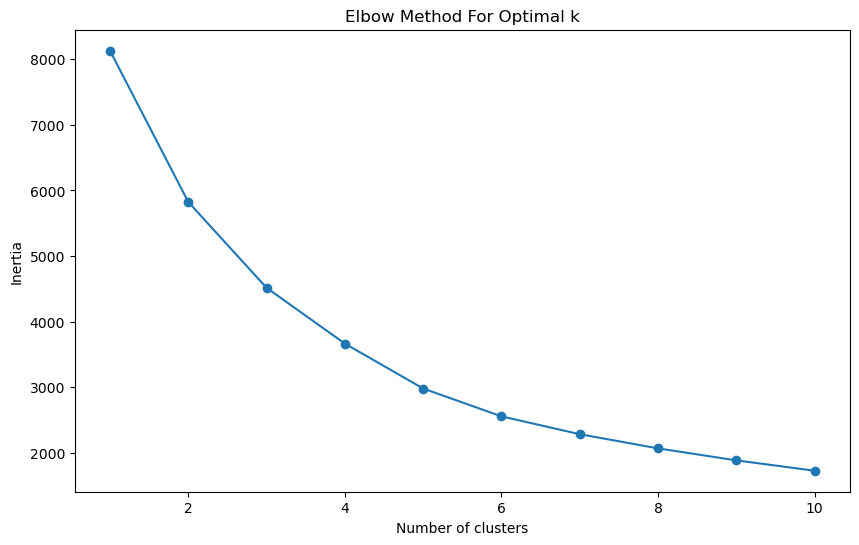

In [11]:
# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=1)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [12]:
# Assuming the elbow is at k=3
kmeans = KMeans(n_clusters=3, n_init = 10, random_state=1)
clusters = kmeans.fit_predict(scaled_features)

# Add clusters back to the original data
user_profiles['Cluster'] = clusters

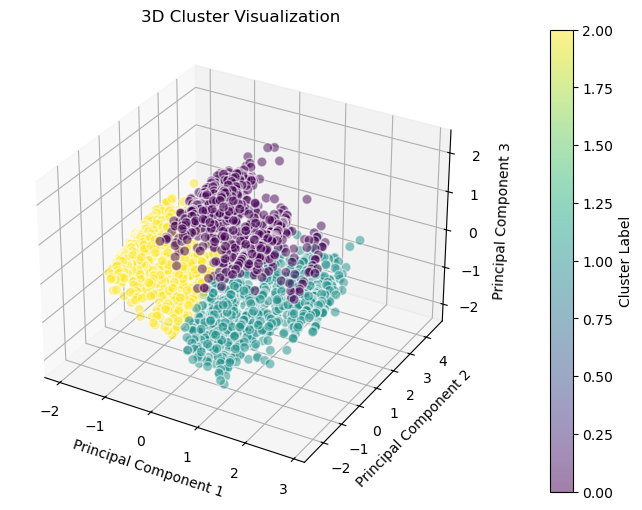

         Book-Author-Encode  Book-Publisher-Encode  Book-Rating
Cluster                                                        
0                      2488                   1277     7.773619
1                      5762                    111     7.731241
2                       364                    111     7.769029


In [13]:
# Visualize clusters in 3D
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_features)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principal_components[:, 0], 
                     principal_components[:, 1], 
                     principal_components[:, 2], 
                     c=clusters, s=50, cmap='viridis', alpha=0.5, edgecolors='w')

# Labeling axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Adding a color bar to understand which color represents which cluster
color_bar = fig.colorbar(scatter, ax=ax, pad=0.1)
color_bar.set_label('Cluster Label')

# Setting title
ax.set_title('3D Cluster Visualization')

# Show plot
plt.show()

# Cluster Profiles
cluster_profiles = user_profiles.groupby('Cluster').agg({
    'Book-Author-Encode': lambda x: x.mode()[0],
    'Book-Publisher-Encode': lambda x: x.mode()[0],
    'Book-Rating': 'mean'
})
print(cluster_profiles)

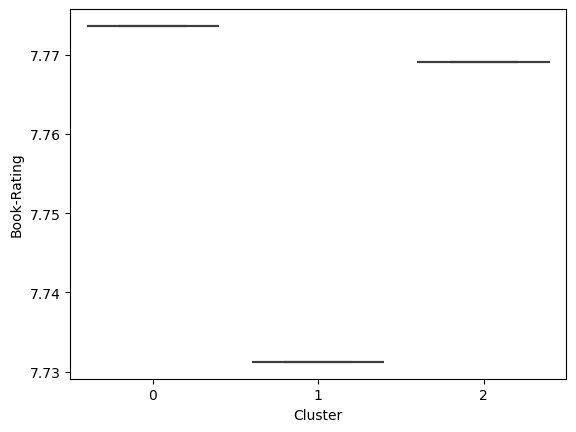

In [14]:
cluster_profiles['Cluster'] = cluster_profiles.index
sns.boxplot(x='Cluster', y='Book-Rating', data=cluster_profiles)
plt.show()

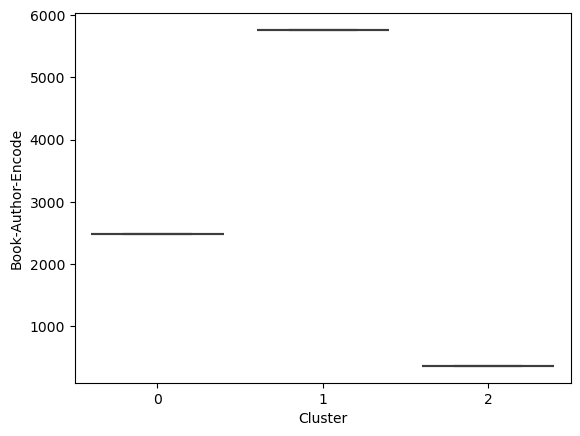

In [15]:
sns.boxplot(x='Cluster', y='Book-Author-Encode', data=cluster_profiles)
plt.show()

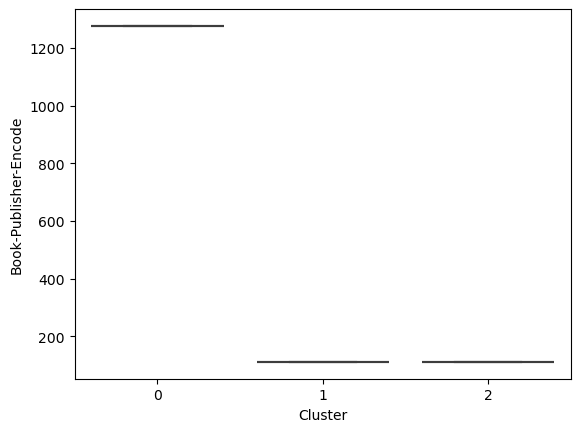

In [16]:
cluster_profiles['Cluster'] = cluster_profiles.index
sns.boxplot(x='Cluster', y='Book-Publisher-Encode', data=cluster_profiles)
plt.show()